In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


open link "Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id....." click next to get a authorization code. Paste in the text box and press enter.
then press runtime->run after.

In [0]:
!unzip "/content/gdrive/My Drive/train.zip" -d data
!unzip "/content/gdrive/My Drive/test.zip" -d data

Archive:  /content/gdrive/My Drive/train.zip
   creating: data/train/
   creating: data/train/Fat Hen/
  inflating: data/train/Fat Hen/5bdfa3a44.png  
  inflating: data/train/Fat Hen/a86b9c0cd.png  
  inflating: data/train/Fat Hen/f3f6559bf.png  
  inflating: data/train/Fat Hen/946b48f62.png  
  inflating: data/train/Fat Hen/4d7fd4020.png  
  inflating: data/train/Fat Hen/2509e5bc5.png  
  inflating: data/train/Fat Hen/e2462573b.png  
  inflating: data/train/Fat Hen/7e98e4aa6.png  
  inflating: data/train/Fat Hen/075cb6666.png  
  inflating: data/train/Fat Hen/b43d0a350.png  
  inflating: data/train/Fat Hen/afac20b21.png  
  inflating: data/train/Fat Hen/4d2efbb45.png  
  inflating: data/train/Fat Hen/f0923dcd6.png  
  inflating: data/train/Fat Hen/180f41d53.png  
  inflating: data/train/Fat Hen/bfdeafadd.png  
  inflating: data/train/Fat Hen/ac6625b0f.png  
  inflating: data/train/Fat Hen/ba5c8f87f.png  
  inflating: data/train/Fat Hen/e7d278e0e.png  
  inflating: data/train/Fat Hen/e

In [0]:
ls 

data/  gdrive/  sample_data/


In [0]:
import os
print(os.listdir('data/train/'))

['Sugar beet', 'Scentless Mayweed', 'Cleavers', 'Shepherds Purse', 'Charlock', 'Common Chickweed', 'Loose Silky-bent', 'Maize', 'Black-grass', 'Common wheat', 'Small-flowered Cranesbill', 'Fat Hen']


In [0]:
import fnmatch
import os
import numpy as np
import pandas as pd
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
np.random.seed(21)

path = 'data/train/'
train_label = []
train_img = []
label2num = {'Loose Silky-bent':0, 'Charlock':1, 'Sugar beet':2, 'Small-flowered Cranesbill':3,
             'Common Chickweed':4, 'Common wheat':5, 'Maize':6, 'Cleavers':7, 'Scentless Mayweed':8,
             'Fat Hen':9, 'Black-grass':10, 'Shepherds Purse':11}
for i in os.listdir(path):
    label_number = label2num[i]
    new_path = path+i+'/'
    for j in fnmatch.filter(os.listdir(new_path), '*.png'):
        temp_img = image.load_img(new_path+j, target_size=(128,128))
        train_label.append(label_number)
        temp_img = image.img_to_array(temp_img)
        train_img.append(temp_img)

train_img = np.array(train_img)

train_y=pd.get_dummies(train_label)
train_y = np.array(train_y)
train_img=preprocess_input(train_img)

print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_y.shape)

Using TensorFlow backend.


Training data shape:  (4750, 128, 128, 3)
Training labels shape:  (4750, 12)


In [0]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16

def vgg16_model(num_classes=None):

    model = VGG16(weights='imagenet', include_top=False,input_shape=(128,128,3))
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-2].outbound_nodes= []
    x=Conv2D(256, kernel_size=(2,2),strides=2)(model.output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Flatten()(x)
    x=Dense(num_classes, activation='softmax')(x)

    model=Model(model.input,x)

    for layer in model.layers[:15]:

        layer.trainable = False


    return model



In [0]:

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score


In [0]:
from keras import backend as K
num_classes=12
model = vgg16_model(num_classes)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy',fscore])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_____

In [0]:
#Split training data into rain set and validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.1, random_state=42)

from keras.callbacks import ModelCheckpoint
epochs = 10
batch_size = 32
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

model.fit(X_train,Y_train,
          batch_size=128,
          epochs=20,
          verbose=1, shuffle=True, validation_data=(X_valid,Y_valid), callbacks=[model_checkpoint])

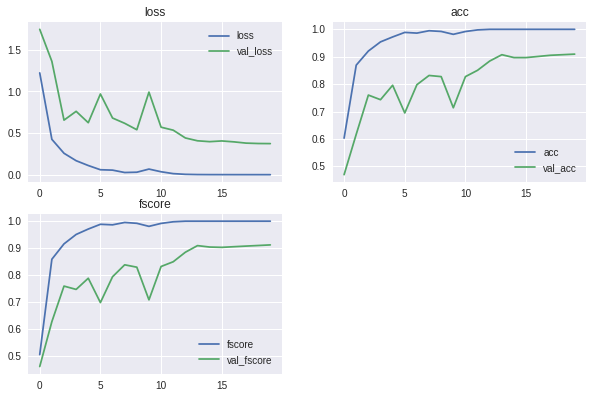

In [0]:
import matplotlib.pyplot as plt
def plot_model(model):
    plots = [i for i in model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(10,10))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.history.history[p], label=p)
        plt.plot(model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

In [0]:
model.load_weights('weights.h5')

In [0]:
prob=[]
num=[]
test_img=[]
test_path = 'data/test/'
test_all = fnmatch.filter(os.listdir(test_path), '*.png')

test_img=[]
for i in range(len(test_all)):
    path=test_path+'/'+test_all[i]
    temp_img=image.load_img(path,target_size=(128,128))
    temp_img=image.img_to_array(temp_img)
    test_img.append(temp_img) 
test_img=np.array(test_img)    
test_img=preprocess_input(test_img)


test_labels=[]
pred=model.predict(test_img)
num2label =  {0:'Loose Silky-bent', 1:'Charlock',2: 'Sugar beet',3: 'Small-flowered Cranesbill',
              4:'Common Chickweed',5: 'Common wheat',6: 'Maize', 7:'Cleavers', 8:'Scentless Mayweed',
             9: 'Fat Hen', 10:'Black-grass', 11:'Shepherds Purse'}
for i in range(len(test_all)):
    max_score =0
    lab=-1
    for j in range(12):
        if pred[i][j]>max_score:
            max_score=pred[i][j]
            lab=j
    test_labels.append(num2label[lab])


d = {'file': test_all, 'species': test_labels}
df = pd.DataFrame(data=d)
print(df.head(6))

            file                    species
0  2b55a2da2.png                   Charlock
1  a0f37c726.png  Small-flowered Cranesbill
2  089ad62a7.png           Common Chickweed
3  a35fd6fbb.png           Common Chickweed
4  37e545a60.png           Common Chickweed
5  a2c89c367.png                   Charlock


In [0]:
#Convert dataframe to csv
df.to_csv("data/submit.csv",index=False) 

In [0]:
ls data/test | head -5


0021e90e4.png
003d61042.png
007b3da8b.png
0086a6340.png
00c47e980.png


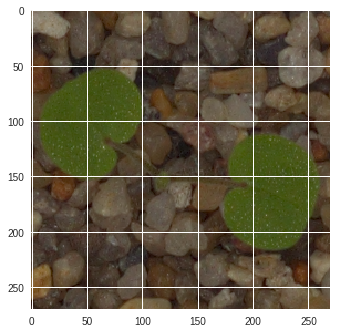

Small-flowered Cranesbill


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
path = 'data/test/0021e90e4.png'
img=mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show() 
test_img=[]
temp_img=image.load_img(path,target_size=(128,128))
temp_img=image.img_to_array(temp_img)
test_img.append(temp_img) 
test_img=np.array(test_img)    
test_img=preprocess_input(test_img)
test_labels=[]
pred=model.predict(test_img)
for i in range(len(test_img)):
    max_score =0
    lab=-1
    for j in range(12):
        if pred[i][j]>max_score:
            max_score=pred[i][j]
            lab=j
    test_labels.append(num2label[lab])
d = {'file': test_all, 'species': test_labels}
print(test_labels[0])